<a href="https://colab.research.google.com/github/sreehari59/Polar-Embedding/blob/main/Polar_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gensim
from numpy import linalg
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from gensim.test.utils import datapath

# This is for the plotly subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# This is to load file from google drive
from google.colab import drive
drive.mount('/content/drive')

# This is to download csv file
from google.colab import files

import random
import scipy


!pip install ipython-autotime
%load_ext autotime

Mounted at /content/drive
time: 187 µs (started: 2022-05-18 22:14:23 +00:00)


In [3]:
def unzipping_file():
  !wget https://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove*.zip # When it is unzipped you can see the different set of dimension it can have that is 25d, 50d, 100d or 200d

time: 1.51 ms (started: 2022-05-18 22:14:23 +00:00)


In [4]:
def model_initialization(unzippedname, new_name):
  model_glove = glove2word2vec(unzippedname,new_name)
  model_glove = gensim.models.KeyedVectors.load_word2vec_format(new_name, binary=False)
  return model_glove

time: 2.26 ms (started: 2022-05-18 22:14:23 +00:00)


In [5]:
def generate_norm_embedding(model, output_path):
    temp_file = open(output_path,'wb')
    temp_file.write(str.encode(str(len(model.vocab))+' '+str(model.vector_size)+'\n'))
    
    for each_word in tqdm(model.vocab):
        temp_file.write(str.encode(each_word+' '))  
        temp_file.write(model[each_word]/linalg.norm(model[each_word]))
        temp_file.write(str.encode('\n'))
    
    
    temp_file.close()
    return output_path

time: 5.33 ms (started: 2022-05-18 22:14:23 +00:00)


In [6]:
def load_normalized_embedding(output_file_name):
  return gensim.models.KeyedVectors.load_word2vec_format(output_file_name,binary=True)

time: 1.6 ms (started: 2022-05-18 22:14:23 +00:00)


**Loading the Antonym**

In [7]:
def load_antonyms(list_new,current_model):
  list_new= list(dict.fromkeys(list_new).keys())

  similarity_matrix = defaultdict(list)
  for each_pair in tqdm(list_new):
      word1 = each_pair[0]
      word2 = each_pair[1]
      if word1 < word2:
          similarity_matrix[word1].append(word2)
      else:
          similarity_matrix[word2].append(word1)

  all_similarity = defaultdict(dict)
  for each_key in tqdm(similarity_matrix):
      for each_value in similarity_matrix[each_key]:
  #         cosine_similarity([current_model[each_key]]
          try:
            all_similarity[each_key][each_value] = abs(cosine_similarity([current_model[each_key]],[current_model[each_value]])[0][0])
          except:
            print("The word is not in the vocabulary : ",each_key," ",each_value)

  final_list = []
  for index_counter, each_key in enumerate(tqdm(all_similarity)):
  #     print(each_key,all_similarity[each_key])
      listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
  #     print(listofTuples)
      final_list.append((each_key, listofTuples[0][0]))
  print(len(final_list))

  list_antonym = final_list
  
  return list_antonym

time: 32.1 ms (started: 2022-05-18 22:14:23 +00:00)


**Find the antonym difference vectors**

In [8]:
def antonym_difference_vector(list_antonym,current_model):
  num_antonym  = len(list_antonym)
  antonymy_vector = []
  for each_word_pair in list_antonym:
      antonymy_vector.append(current_model[each_word_pair[0]]- current_model[each_word_pair[1]])
      
  antonymy_vector = np.array(antonymy_vector)
  print(antonymy_vector.shape)
  print(antonymy_vector)
  return antonymy_vector

time: 4.81 ms (started: 2022-05-18 22:14:24 +00:00)


In [9]:
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim,antonymy_vector):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    new_embedding_dict = transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

    return new_embedding_dict

time: 6.23 ms (started: 2022-05-18 22:14:24 +00:00)


In [10]:
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):

    temp_dict = dict()

    embedding_size = current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    #print('New model size is',len(current_model), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])

        new_vector = new_vector/linalg.norm(new_vector)
        temp_dict[each_word] = new_vector
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()
    return temp_dict

time: 21.5 ms (started: 2022-05-18 22:14:24 +00:00)


In [11]:
def make_polar_dict(company_name, antonym, embedding, top_n = False, n = 10):
  temp_dict = dict()
  temp_polar = embedding[company_name]

  if top_n:
    idx = np.argsort([abs(x) for x in temp_polar])[-n:]
    for i in idx:
      print(antonym[i],temp_polar[i],'\n')


  if len(antonym) == len(temp_polar):
    for a in range(len(antonym)):
      temp_dict[antonym[a]] = temp_polar[a]
    return temp_dict

time: 6.66 ms (started: 2022-05-18 22:14:24 +00:00)


In [12]:
def download_csv_file(df,filename):
  df.to_csv(filename)
  files.download(filename)

time: 1.66 ms (started: 2022-05-18 22:14:24 +00:00)


**The below function will input the antonym pair from the user**

In [13]:
def user_antonym_input(list_new,user_list):
  list_new.append(user_list)
  return list_new

time: 1.73 ms (started: 2022-05-18 22:14:24 +00:00)


**The below function will find words simliar to the given antonym pair**

In [14]:
def similar_antonym_pair(list_new,antonym_pair,current_model):
  first_word = antonym_pair.split("-")[0]
  second_word = antonym_pair.split("-")[1]

  similar_word_list1 = current_model.similar_by_word(first_word)
  similar_word_list2 = current_model.similar_by_word(second_word)
  for i in range(0,5):
    
    new_antonym_word1 = similar_word_list1[i][0]
    new_antonym_word2 = similar_word_list2[i][0]   
   
    antonym_tuple = (new_antonym_word1,new_antonym_word2)
    
    list_new.append(antonym_tuple)
    clear_tuple(antonym_tuple)
    
  return list_new

time: 11.7 ms (started: 2022-05-18 22:14:24 +00:00)


In [15]:
def clear_tuple(tuples):
  temp = list(tuples)
  temp.clear()
  tuples = tuple(temp)
  return tuples

time: 2.19 ms (started: 2022-05-18 22:14:24 +00:00)


In [64]:
def polar_list(list):
  
  right_polar_list = []
  left_polar_list = []
  for i in range(0,len(list)):
    
    right_polar_list.append(list[i][0])
    left_polar_list.append(list[i][1])

  return right_polar_list,left_polar_list



time: 3.14 ms (started: 2022-05-18 22:37:31 +00:00)


**The below function will create an alphabetical list just like columns of polar embeddings**

In [17]:
def alphabetical_list_creation(list):
  new_list = []
  
  for i in range(0,len(list)):
    
    if list[i][0] < list[i][1]:
      val = list[i][0]+"-"+list[i][1]
      new_list.append(val)
      
    else:
      val = list[i][1]+"-"+list[i][0]
      new_list.append(val)
      
  return new_list

time: 6.87 ms (started: 2022-05-18 22:14:24 +00:00)


**Below function will append the antonym pair to the list_new**

In [18]:
def append_to_list(list_source,list_target):
  for i in list_source:
    list_target.append(i)
  return list_target

time: 1.99 ms (started: 2022-05-18 22:14:24 +00:00)


**Below function will give 5 random words from the list**

In [63]:
def random_word_list(number_of_elements):  
  list_antonym = []  
  with open('/content/drive/MyDrive/LenciBenotto.val') as fp:
      for line in fp:
          parts = line.split() # The line is split into 4 parts as there are 3 space in between
          if parts[3]=='antonym': # Here we if the the 4th part that is parts[3] in the line is antonym then that line is selected
              word1 = parts[0].split('-')[0]
              word2 = parts[1].split('-')[0]
              if word1 in current_model and word2 in current_model: # If both the words are there in the model then it is appended to the list
                  list_antonym.append((word1.strip().lower(), word2.strip().lower()))
  
  return random.sample(list_antonym, number_of_elements)

time: 5.08 ms (started: 2022-05-18 22:37:24 +00:00)


In [19]:
unzipping_file()
model_glove = model_initialization('glove.6B.300d.txt','gensim_glove.6B.300d.txt')
path = generate_norm_embedding(model_glove,'glove_norm_wiki.mod')
current_model  = load_normalized_embedding(path)

--2022-05-18 22:14:24--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-18 22:14:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.07MB/s    in 2m 40s  

2022-05-18 22:17:05 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/400000 [00:00<?, ?it/s]

time: 4min 34s (started: 2022-05-18 22:14:24 +00:00)


In [147]:
'''('individualism', 'collectivism'),
('long-term', 'short-term'),
('indulgence', 'restraint'),'''

random_list = random_word_list(5)

individual_list= [('masculinity', 'femininity')]

human_code_list = [('achievement', 'support'),
           ('competitive', 'caring'),
           ('assertive', 'submissive'),
           ('ambitious', 'unambitious'),
           ('sucess','cooperation')
           ]


similar_antonym_pair_list = []
similar_antonym_pair_list = similar_antonym_pair(similar_antonym_pair_list,'achievement-caring' ,current_model) 
print(similar_antonym_pair_list)

[('achievements', 'loving'), ('accomplishment', 'nurturing'), ('excellence', 'cared'), ('accomplishments', 'care'), ('award', 'sick')]
time: 112 ms (started: 2022-05-18 23:08:12 +00:00)


In [148]:
list_new = []
list_new = append_to_list(human_code_list,list_new)
list_new = append_to_list(individual_list,list_new)
list_new = append_to_list(similar_antonym_pair_list,list_new)
list_new = append_to_list(random_list,list_new)


right_polar_list_human,left_polar_list_human = polar_list(human_code_list)
right_polar_list_individual,left_polar_list_individual = polar_list(individual_list)
right_polar_list_similar,left_polar_list_similar = polar_list(similar_antonym_pair_list)
right_polar_list_random,left_polar_list_random = polar_list(random_list)

input_list_human = alphabetical_list_creation(human_code_list)
input_list_individual = alphabetical_list_creation(individual_list)
input_list_similar = alphabetical_list_creation(similar_antonym_pair_list)
input_list_random = alphabetical_list_creation(random_list)

time: 12.1 ms (started: 2022-05-18 23:08:13 +00:00)


In [149]:
list_antonym  = load_antonyms(list_new,current_model)
len(list_new)
antonymy_vector = antonym_difference_vector(list_antonym,current_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/16 [00:00<?, ?it/s]

16
(16, 300)
[[ 0.14758141  0.09032236  0.07620825 ...  0.12463442  0.00482126
  -0.03302358]
 [-0.09652946 -0.07345466 -0.0032986  ...  0.12112679  0.01148236
  -0.0293146 ]
 [-0.05397214  0.02136535 -0.00466404 ... -0.04937481 -0.06371355
  -0.00237834]
 ...
 [ 0.01651911  0.08178712  0.06710561 ...  0.02259391  0.00301024
  -0.04462638]
 [-0.09338193 -0.09850722  0.02722044 ...  0.0792646   0.05936655
   0.10006116]
 [-0.00401743 -0.01209438 -0.06920309 ...  0.00370789 -0.04570928
   0.17775726]]
time: 190 ms (started: 2022-05-18 23:08:13 +00:00)


**Below function will read the comapny name and make the word embeddings**

In [150]:
def read_company_make_word_embedding(file_path,current_model):
  company = pd.read_csv(file_path,encoding= 'unicode_escape')
  name_list = company['0']
  name_word_embedding = dict()
  new_name_list=[]
  for name in name_list:
    try:
      name_word_embedding[name] = current_model[name]
      new_name_list.append(name)
    except:
      print("The company is not there: ",name)
  return new_name_list,name_word_embedding

time: 8.54 ms (started: 2022-05-18 23:08:13 +00:00)


In [151]:
# Below function will read the comapny name and make the word embeddings
new_name_list,name_word_embedding = read_company_make_word_embedding("/content/drive/MyDrive/International_Fortune_GloVe.csv",current_model)

random_antonym_vector = [i for i in range(len(antonymy_vector))]
random.shuffle(random_antonym_vector)
print(len(random_antonym_vector))

# Below function will generate the polar embeddings
name_new_embedding = generate_embedding_path(name_word_embedding, 'test_run',True ,random_antonym_vector,500,antonymy_vector)

antonym_500 = [list_antonym[x] for x in random_antonym_vector[:500]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



The company is not there:  jpmorganchase
The company is not there:  generalmotors
The company is not there:  fanniemae
The company is not there:  bankofamerica
The company is not there:  nestlÃ©
The company is not there:  wellsfargo
The company is not there:  generalelectric
The company is not there:  sinopharm
The company is not there:  freddiemac
The company is not there:  waltdisney
The company is not there:  engie
The company is not there:  morganstanley
The company is not there:  indianoil
The company is not there:  telefÃ³nica
The company is not there:  bestbuy
The company is not there:  talanx
The company is not there:  abbvie
The company is not there:  americanexpress
The company is not there:  deutschebank
The company is not there:  tatamotors
The company is not there:  l'orÃ©al
The company is not there:  angloamerican
The company is not there:  achmea
The company is not there:  dollartree
The company is not there:  riteaid
16


  0%|          | 0/142 [00:00<?, ?it/s]

time: 121 ms (started: 2022-05-18 23:08:13 +00:00)


**Polar Embedding -> DataFrame**

In [152]:
def polar_embedding_to_df(new_name_list, name_new_embedding, antonym_500):
  df = dict()
  for t in new_name_list:
    df[t] = make_polar_dict(t, antonym_500, name_new_embedding)

  new_df = pd.DataFrame(df).transpose()


  # change columns to better read names
  new_columns = []

  for pair in antonym_500:
    temp = pair[0]+''+pair[1]
    new_columns.append(temp)

  new_df.columns = new_columns

  return new_df

time: 12.8 ms (started: 2022-05-18 23:08:13 +00:00)


In [153]:
new_df = polar_embedding_to_df(new_name_list, name_new_embedding, antonym_500)
new_df.head()

fortune_500_company = pd.read_csv('/content/drive/MyDrive/Fortune Global 500 companies.csv',encoding= 'unicode_escape')
fortune_500_company['Company'] = fortune_500_company['Company'].str.lower()
fortune_500_company['Company'] = fortune_500_company['Company'].str.replace(" ","")

polar_embedding = pd.merge(fortune_500_company,new_df,how="right",left_on="Company",right_on=new_df.index)

polar_embedding.drop(['Rank'],axis=1) # This will drop the column Rank

,Company,Location,achievementsupport,ambitiousunambitious,lopsecure,flickpunch,cooperationsucess,fanwarm,accomplishmentnurturing,achievementsloving,caringcompetitive,accomplishmentscare,caredexcellence,assertivesubmissive,awardsick,femininitymasculinity,blueberryradish,birdcrab
0,walmart,USA,0.010466,-0.336565,0.343178,0.170456,-0.294702,-0.162813,-0.129246,0.157173,-0.499655,-0.474755,-0.147097,0.031362,-0.071586,0.269341,-0.023980,-0.095445
1,amazon,USA,-0.251934,0.424254,0.175331,-0.032414,0.104243,-0.156932,-0.112076,0.269719,-0.089348,-0.409387,0.104048,-0.213981,0.420040,-0.193859,0.352137,0.183663
2,apple,USA,-0.111392,0.294266,0.076480,-0.319122,0.011651,0.066346,-0.082080,-0.008214,-0.096817,-0.090868,-0.045762,0.132394,0.060847,0.768820,0.341859,-0.181832
3,volkswagen,Germany,-0.316564,0.269811,0.201079,0.351458,0.168729,0.104682,0.178318,0.113071,-0.467262,-0.028821,-0.119827,-0.491863,-0.097683,0.225362,-0.118295,0.171020
4,mckesson,USA,0.161108,-0.453385,-0.143235,0.022494,-0.260899,-0.093519,0.374136,-0.061313,0.169587,-0.416923,-0.062828,0.333851,0.067384,-0.109706,-0.420410,-0.124918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,netflix,USA,-0.158525,-0.478762,-0.236856,0.369447,-0.229668,-0.043181,0.167971,0.221684,-0.253337,-0.320431,0.188188,0.209335,0.304844,0.171641,-0.035740,-0.226573
138,nokia,Finland,-0.363733,-0.018661,-0.022420,-0.070554,0.034353,-0.171686,-0.111482,0.336576,-0.346077,-0.327987,-0.093356,-0.075404,0.294859,0.576088,-0.210969,0.020723
139,synnex,USA,0.404129,-0.412580,-0.082891,0.140207,-0.166771,0.237562,-0.206429,-0.241452,0.052325,0.531811,-0.166233,0.190898,-0.252789,-0.077036,-0.031547,-0.185203
140,holcim,Switzerland,0.226615,-0.572037,0.152232,0.062466,-0.093881,-0.096072,-0.458046,0.152944,-0.040773,-0.066725,-0.086516,-0.031019,0.488467,0.010183,0.291749,0.068689


time: 62 ms (started: 2022-05-18 23:08:13 +00:00)


In [154]:
# This will find the total number of companies in our data frame based on Location
total_company_list_based_on_loc = polar_embedding['Location'].value_counts()
total_company_count_df = pd.DataFrame({'Country':total_company_list_based_on_loc.index, 'Total Count':total_company_list_based_on_loc.values})
print(total_company_count_df.head())

   Country  Total Count
0      USA           52
1    Japan           18
2  Germany           12
3  Britain           10
4   France            9
time: 8.94 ms (started: 2022-05-18 23:08:13 +00:00)


In [155]:
def company_count(company_df,input_list,polar_embedding):  

  # we then find the number of companies grouped on the basis of location
  for i in input_list:
    print(i)
    j = i.replace("-","")
    subset_df2 = polar_embedding[polar_embedding[j] < 0]
    company_inclined_to_left_polar_df1 = subset_df2['Location'].value_counts()
    left_polar = i.split("-")[0]
    company_inclined_to_left_polar_df1 = pd.DataFrame({'Country':company_inclined_to_left_polar_df1.index, left_polar :company_inclined_to_left_polar_df1.values})
    company_df=pd.merge(company_df, company_inclined_to_left_polar_df1, how='left',on='Country')    
    company_df[left_polar] = round( company_df[left_polar] / company_df.iloc[:,1] * 100)

    subset_df1 = polar_embedding[polar_embedding[j] > 0]
    company_inclined_to_right_polar_df1 = subset_df1['Location'].value_counts()
    right_polar = i.split("-")[1]
    company_inclined_to_right_polar_df1 = pd.DataFrame({'Country':company_inclined_to_right_polar_df1.index, right_polar :company_inclined_to_right_polar_df1.values})
    company_df=pd.merge(company_df, company_inclined_to_right_polar_df1, how='left',on='Country')    
    company_df[right_polar] = round( company_df[right_polar] / company_df.iloc[:,1] * 100)


  company_df = company_df.fillna(0)

  # We are considering only the countries if the numberof companies in the country is over 3
  company_df = company_df[company_df['Total Count'] > 3]

  return company_df

time: 20.9 ms (started: 2022-05-18 23:08:13 +00:00)


In [156]:
company_df=total_company_count_df.copy()

company_df = company_count(company_df,input_list_human,polar_embedding)
company_df = company_count(company_df,input_list_individual,polar_embedding)
company_df = company_count(company_df,input_list_similar,polar_embedding)
company_df = company_count(company_df,input_list_random,polar_embedding)

achievement-support
caring-competitive
assertive-submissive
ambitious-unambitious
cooperation-sucess
femininity-masculinity
achievements-loving
accomplishment-nurturing
cared-excellence
accomplishments-care
award-sick
lop-secure
bird-crab
fan-warm
flick-punch
blueberry-radish
time: 213 ms (started: 2022-05-18 23:08:13 +00:00)


In [157]:
def polar_ranking(polar_list,total_score,ranking,company_df):
  total_sum=0
  total_sum_list=[]
  polar_ranking_list = []
  polar_index=0
  for index,row in company_df.iterrows():  
    
    for i in polar_list:
      
      total_sum = total_sum + (row[i])
    #print(company_df.iloc[index,2:])  
    total_sum_list.append(total_sum/len(polar_list))
    polar_ranking_list.append(index+1)
    total_sum = 0

  company_df[total_score] = total_sum_list
  company_df= company_df.sort_values(by=[total_score],ascending=False)
  company_df[ranking] = polar_ranking_list

  return company_df

time: 8.26 ms (started: 2022-05-18 23:08:13 +00:00)


In [158]:
company_df = polar_ranking(right_polar_list_human,"Total Score Human","Polar Rank H",company_df)
company_df = polar_ranking(right_polar_list_individual,"Total Score Individual","Polar Rank I",company_df)
company_df = polar_ranking(right_polar_list_similar,"Total Score Similar","Polar Rank S",company_df)
company_df = polar_ranking(right_polar_list_random,"Total Score Random","Polar Rank R",company_df)

time: 16.8 ms (started: 2022-05-18 23:08:13 +00:00)


In [159]:
company_df.head(7)

,Country,Total Count,achievement,support,caring,competitive,assertive,submissive,ambitious,unambitious,...,blueberry,radish,Total Score Human,Polar Rank H,Total Score Individual,Polar Rank I,Total Score Similar,Polar Rank S,Total Score Random,Polar Rank R
2,Germany,12,58.0,42.0,92.0,8.0,67.0,33.0,42.0,58.0,...,75.0,25.0,48.4,5,83.0,6,36.6,2,66.6,7
5,Switzerland,5,40.0,60.0,80.0,20.0,60.0,40.0,100.0,0.0,...,60.0,40.0,52.0,2,40.0,1,48.0,4,56.0,1
4,France,9,67.0,33.0,78.0,22.0,44.0,56.0,67.0,33.0,...,67.0,33.0,51.2,3,89.0,7,42.4,6,55.8,4
6,South Korea,4,75.0,25.0,75.0,25.0,100.0,0.0,75.0,25.0,...,100.0,0.0,70.0,1,50.0,3,55.0,5,55.0,6
3,Britain,10,50.0,50.0,80.0,20.0,60.0,40.0,70.0,30.0,...,80.0,20.0,44.0,7,70.0,2,48.0,1,54.0,2
0,USA,52,67.0,33.0,63.0,37.0,44.0,56.0,58.0,42.0,...,56.0,44.0,47.4,6,73.0,5,50.2,3,45.8,5
1,Japan,18,67.0,33.0,78.0,22.0,78.0,22.0,44.0,56.0,...,72.0,28.0,51.0,4,33.0,4,43.4,7,43.2,3


time: 33.2 ms (started: 2022-05-18 23:08:13 +00:00)


In [160]:
company_df.drop(company_df.iloc[:, 2:2+(len(list_new))*2], axis = 1, inplace = True)
company_df.head(7)

,Country,Total Count,Total Score Human,Polar Rank H,Total Score Individual,Polar Rank I,Total Score Similar,Polar Rank S,Total Score Random,Polar Rank R
2,Germany,12,48.4,5,83.0,6,36.6,2,66.6,7
5,Switzerland,5,52.0,2,40.0,1,48.0,4,56.0,1
4,France,9,51.2,3,89.0,7,42.4,6,55.8,4
6,South Korea,4,70.0,1,50.0,3,55.0,5,55.0,6
3,Britain,10,44.0,7,70.0,2,48.0,1,54.0,2
0,USA,52,47.4,6,73.0,5,50.2,3,45.8,5
1,Japan,18,51.0,4,33.0,4,43.4,7,43.2,3


time: 21.2 ms (started: 2022-05-18 23:08:13 +00:00)


In [161]:
hofstede_df = pd.read_csv("/content/drive/MyDrive/Polar Embedding/Hofstede 6 dimensions.csv",sep=";")
hofstede_df=hofstede_df[hofstede_df.iloc[:,:]!="#NULL!" ]
hofstede_df.dropna(axis=0)

,ctr,Country,Power distance index,Individualism index,Masculinity index,Uncertainty avoidance index,Long term orientation index,Indulgence index
0,AFE,Africa East,64,27,41,52,32,40
1,AFW,Africa West,77,20,46,54,9,78
5,ARA,Arab countries,80,38,53,68,23,34
6,ARG,Argentina,49,46,56,86,20,62
8,AUL,Australia,38,90,61,51,21,71
...,...,...,...,...,...,...,...,...
102,TUR,Turkey,66,37,45,85,46,49
103,USA,USA,40,91,62,46,26,68
106,URU,Uruguay,61,36,38,100,26,53
107,VEN,Venezuela,81,12,73,76,16,100


time: 26.7 ms (started: 2022-05-18 23:08:13 +00:00)


In [162]:
def percentage_difference(hofstede_dimension):

  for index,row in hofstede_df.iterrows():
    if row['Country'] == country_name:
      hofstede_dimension_value = int(row[hofstede_dimension])
    elif row['ctr'] == country_name:
      hofstede_dimension_value = int(row[hofstede_dimension])
  
  mean_value = total_sum/len(polar_list)
  if hofstede_dimension_value > mean_value:
    print("% difference",hofstede_dimension_value - mean_value )
  else:
    print("% difference",mean_value - hofstede_dimension_value )

time: 8.38 ms (started: 2022-05-18 23:08:13 +00:00)


In [163]:
merged_df = pd.merge(company_df, hofstede_df, how='left',on='Country')
merged_df.head(10)

,Country,Total Count,Total Score Human,Polar Rank H,Total Score Individual,Polar Rank I,Total Score Similar,Polar Rank S,Total Score Random,Polar Rank R,ctr,Power distance index,Individualism index,Masculinity index,Uncertainty avoidance index,Long term orientation index,Indulgence index
0,Germany,12,48.4,5,83.0,6,36.6,2,66.6,7,GER,35,67,66,65,83,40
1,Switzerland,5,52.0,2,40.0,1,48.0,4,56.0,1,SWI,34,68,70,58,74,66
2,France,9,51.2,3,89.0,7,42.4,6,55.8,4,FRA,68,71,43,86,63,48
3,South Korea,4,70.0,1,50.0,3,55.0,5,55.0,6,KOR,60,18,39,85,100,29
4,Britain,10,44.0,7,70.0,2,48.0,1,54.0,2,GBR,35,89,66,35,51,69
5,USA,52,47.4,6,73.0,5,50.2,3,45.8,5,USA,40,91,62,46,26,68
6,Japan,18,51.0,4,33.0,4,43.4,7,43.2,3,JPN,54,46,95,92,88,42


time: 27.1 ms (started: 2022-05-18 23:08:13 +00:00)


In [164]:
ranking_list = []
for i in range(1,len(merged_df['Masculinity index'])+1):
  ranking_list.append(i)
merged_df= merged_df.sort_values(by=['Masculinity index'],ascending=False)
merged_df['Masculinity Ranking'] = ranking_list
merged_df.head(10)

,Country,Total Count,Total Score Human,Polar Rank H,Total Score Individual,Polar Rank I,Total Score Similar,Polar Rank S,Total Score Random,Polar Rank R,ctr,Power distance index,Individualism index,Masculinity index,Uncertainty avoidance index,Long term orientation index,Indulgence index,Masculinity Ranking
6,Japan,18,51.0,4,33.0,4,43.4,7,43.2,3,JPN,54,46,95,92,88,42,1
1,Switzerland,5,52.0,2,40.0,1,48.0,4,56.0,1,SWI,34,68,70,58,74,66,2
0,Germany,12,48.4,5,83.0,6,36.6,2,66.6,7,GER,35,67,66,65,83,40,3
4,Britain,10,44.0,7,70.0,2,48.0,1,54.0,2,GBR,35,89,66,35,51,69,4
5,USA,52,47.4,6,73.0,5,50.2,3,45.8,5,USA,40,91,62,46,26,68,5
2,France,9,51.2,3,89.0,7,42.4,6,55.8,4,FRA,68,71,43,86,63,48,6
3,South Korea,4,70.0,1,50.0,3,55.0,5,55.0,6,KOR,60,18,39,85,100,29,7


time: 27.7 ms (started: 2022-05-18 23:08:13 +00:00)


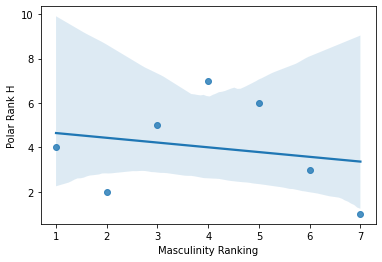

time: 275 ms (started: 2022-05-18 23:08:14 +00:00)


In [165]:
import seaborn as sns

sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank H"])

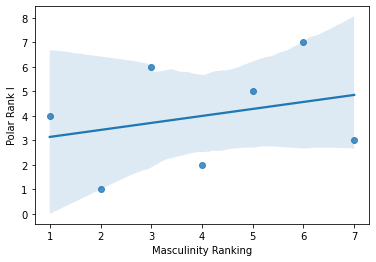

time: 324 ms (started: 2022-05-18 23:08:14 +00:00)


In [166]:
sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank I"])

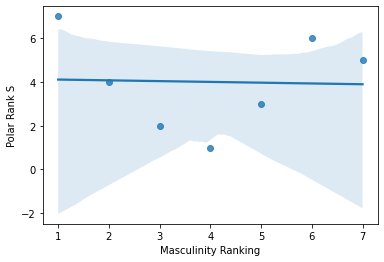

time: 274 ms (started: 2022-05-18 23:08:14 +00:00)


In [167]:
sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank S"])

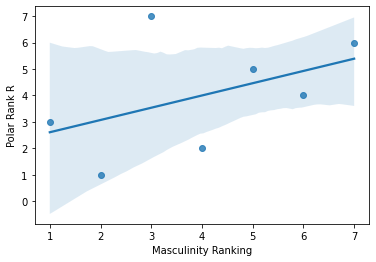

time: 273 ms (started: 2022-05-18 23:08:14 +00:00)


In [168]:
sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank R"])

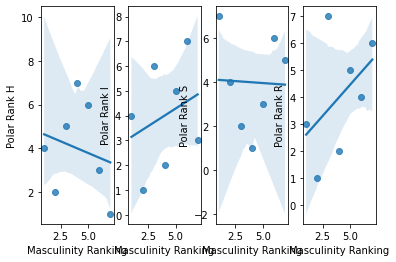

time: 897 ms (started: 2022-05-18 23:08:15 +00:00)


In [169]:
import matplotlib.pyplot as plt

import seaborn as sns


fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4)
sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank H"], ax=ax1)
sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank I"], ax=ax2)

sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank S"], ax=ax3)

sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Rank R"], ax=ax4)


In [170]:
import plotly.graph_objects as go

fig = go.Figure()
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Masculinity index"].astype(int), name = "Hofstede Masculinity Score"),1,1)  
fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Human"].astype(int), name = "Human Polar Score"),1,1)  

fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Masculinity index"].astype(int), name = "Hofstede Masculinity Score"),1,2)  
fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Individual"].astype(int), name = "Individual Polar Score"),1,2)  

fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Masculinity index"].astype(int), name = "Hofstede Masculinity Score"),2,1)  
fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Similar"].astype(int), name = "Similar Polar Score"),2,1)  

fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Masculinity index"].astype(int), name = "Hofstede Masculinity Score"),2,2)  
fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Random"].astype(int), name = "Random Polar Score"),2,2)  
fig.show() 

time: 66.1 ms (started: 2022-05-18 23:08:16 +00:00)


**Below Cell will find the Mean Absolute Errors**

In [171]:
from sklearn.metrics import mean_absolute_error

MAE = []
MAE_of_Score = []

MAE.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Polar Rank H"]))
MAE.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Polar Rank I"]))
MAE.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Polar Rank S"]))
MAE.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Polar Rank R"]))

MAE_of_Score.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Total Score Human"]))
MAE_of_Score.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Total Score Individual"]))
MAE_of_Score.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Total Score Similar"]))
MAE_of_Score.append(mean_absolute_error(merged_df["Masculinity Ranking"], merged_df["Total Score Random"]))

time: 13.3 ms (started: 2022-05-18 23:08:16 +00:00)


**Below Cell will find the correlation**

In [172]:
correlation = []
correlation.append(merged_df["Polar Rank H"].corr(merged_df["Masculinity Ranking"]))
correlation.append(merged_df["Polar Rank I"].corr(merged_df["Masculinity Ranking"]))
correlation.append(merged_df["Polar Rank S"].corr(merged_df["Masculinity Ranking"]))
correlation.append(merged_df["Polar Rank R"].corr(merged_df["Masculinity Ranking"]))

time: 6.17 ms (started: 2022-05-18 23:08:16 +00:00)


**Below cell will create the final table with evaluation results**

In [173]:
eval_data = {"Mean Absolute Error of Rank" : MAE,
              "Correlation" : correlation,
             "Mean Absolute Error of Score" : MAE_of_Score
            }

eval_df = pd.DataFrame(eval_data, index =["Human Made List", "Individual List", "Similar List","Random List"])
eval_df.head()

,Mean Absolute Error of Rank,Correlation,Mean Absolute Error of Score
Human Made List,2.571429,-0.214286,48.000000
Individual List,2.000000,0.285714,58.571429
Similar List,2.285714,-0.035714,42.228571
Random List,1.714286,0.464286,49.771429


time: 19.9 ms (started: 2022-05-18 23:08:16 +00:00)
